
# PA ST 810: Convolutional Neural Network
## Homework 1: Artificial Neural Networks, Model Interpretation, and Regularization

**GEC**<br/>
**Instructor**: Pavlos Protopapas<br />
**Maximum Score**: 100

<hr style="height:2.4pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML

In [2]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(40) # ERROR

%matplotlib inline

### INSTRUCTIONS


- This homework is a jupyter notebook. Download and work on it on your local machine.

- This homework should be submitted in pairs.

- Ensure you and your partner together have submitted the homework only once. Multiple submissions of the same work will be penalised and will cost you 2 points.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. 

- To submit the homework, either one of you upload the working notebook on edStem and click the submit button on the bottom right corner.

- Submit the homework well before the given deadline. Submissions after the deadline will not be graded.

- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.

- Comment your code well. This would help the graders in case there is any issue with the notebook while running. It is important to remember that the graders will not troubleshoot your code. 

- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example: 
```
print(f'The R^2 is {R:.4f}')
```
- Your plots should include clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95 % confidence interval of coefficients of polynomial degree 5" is).

- **Ensure you make appropraite plots for all the questions it is applicable to, regardless of it being explicitly asked for.**

<hr style="height:2pt">

### Names of the people who worked on this homework together
Hansheng Li  
Zhenghao Jia  
Yuhui Wu  
Zijian Wang  

<a id="contents"></a>

## Notebook Contents

- [**PART 1 [50 pts]: Model interpretation and predictive intervals in NN**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**PART 2 [50 pts]: Kannada MNIST Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The Kannada MNIST Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


---

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
<h1> PART 1 [50 pts]: Model interpretation and predictive intervals in NN </h1> 

<br />


<a id="part1intro"></a>

<b> Overview and Data Description </b>
<br /><br />
[Return to contents](#contents)
<br />
In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival based on features that could be measured as the flight takes off.  
We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.  


The included variables are:
<br /><br />
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).
<br /><br />
**DISTANCE**: the distance between arrival and departure airports, in miles.
<br /><br />
**SCHEDULED_TIME**: the flight's scheduled travel time.
<br /><br />
**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.
<br /><br />
**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).
<br /><br />
**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).
<br /><br />
**FLIGHT_COUNT**: the number of flights flying out of that airport before noon on a typical day.
<br /><br />
**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.
<br /><br />
**ORIGIN_AIRPORT**: the airport the flight took off from.
<br /><br />
**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.
<br /><br />
For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.
<br /><br />
**NOTE:** The observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

</div> 

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

<h2>PART 1: Questions</h2> 
<br /><br />
    
[Return to contents](#contents)

<br /><br />
**1.1.1 [5 points]**  Read in the dataset `flights.csv`. Create a variable `DELAY_OR_NOT` that denotes whether `ARRIVAL_DELAY` is greater than or equal to 15 minutes (the FAA and BTS define a flight as delayed only if it arrives 15 minutes late or more). This is going to be the response variable for the rest of this question. 
<br /><br />
**1.1.2 [5 points]** Preprocess the data: one-hot-encode the non-numeric categorical variables, deal with missing values if there are any, scale your data, and split the data into training and test sets (use an 80/20 split with `random_state=111`). Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets.
<br /><br />
**1.2 [5 points]** Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use appropriate activation functions for each layer, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for an appropriate number of epochs based on the results of your training and validation accuracy plot, and feel free to use the default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model` training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.
<br /><br />
**1.3 [10 points]** To begin our interpretation of the resulting `NN_model`, we will first use a "proxy model" that we know how to interpret and train it on our `NN_model` training predictions.

<br /><br />
- **1.3.1** For this we need to modify our training set. First, generate a set of `NN_model` class predictions for the training set. These training predictions will be used to form a revised training dataset for our proxy model: (a) use all of the same $X$ values used by `NN_model` for our $X$ train and (b) replace the actual response values $y$ with the predicted $\hat{y}$ values generated by the fitted `NN_model`.

<br /><br />
- **1.3.2** Next, fit a logistic regression model using your revised training dataset from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Print the `logreg` test accuracy to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.

<br /><br />
- **1.3.3** Now use sklearn's `permutation_importance` class (already included in this notebook's imports) to compute the feature importance using the `logreg` model.
<br />
  - Read the official documentation for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html#:~:text=The%20permutation%20feature%20importance%20is,model%20depends%20on%20the%20feature.) as well as [here](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) to learn how it works.
<br />
  - You can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.
<br />
  - Measure the **relative** variable importance (i.e. as a proportion of the variable importance of the most important variable identified by `permutation_importance`) and generate a barplot illustrating the relative variable importances for the top-10 most important predictors identified using `permutation_importance`.
<br /><br />

**1.4 [10 points]** Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. **For all 1.4 plots below**, for ease of interpretation, **please be certain to** display all predictors on their original scales. 
<br /><br />

   - **1.4.1** Set all predictors to their means/modes except for `SCHED_DEP_HOUR`. Predict the probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences.
<br /><br />
 
   - **1.4.2** Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `FLIGHT_COUNT` from the training set (see the question 1.4 "HINT" below).

<br /><br />
   - **1.4.3**   Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` from the training set.

<br /><br />
   - **1.4.4** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `DISTANCE` from the training set. 
<br /><br />

  - **1.4.5** In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.
<br /><br />
**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your datapoints based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. Please refer to the matplotlib documentation for examples.
<br /><br />
    
**1.5 [5 points]**
    
<br /><br />
In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 
<br /><br />
Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (a minimum of at least 50 bootstraps should be used). Predict the output on the test data for each model. Randomly select 8 test observations and on 8 subplots, plot the distribution of predicted probabilities (i.e. $n$ bootstrapped probabilites) with the 95% CI bounds clearly marked and reported in each subplot and the actual class of each observation included in each subplot's title for easy reference.
    <br /><br />
Interpret what you see in 3-5 sentences.
<br /><br />
    
**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the provided `progressbar` function below to visually track the progress of your bootstraps.
    
<br /><br />
    
**1.6 [10 points]**
    
<br /><br />
Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how "significant" our bagged (i.e. bootstrap-aggregated) prediction will be for each test observation.
<br /><br />
To accomplish this, you will first calculate the ratio of bootstrapped probabilities that cross the threshold value of $\hat{p}=0.5$. Let's call this ratio the **Posterior Prediction Ratio (PPR)**. When a bagged prediction's $PPR=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPR=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPR$ values for all test observations, you should have $n=2000$ $PPR$ values (i.e. one for each test observation).
<br /><br />
Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for significance (i.e. maximum $PPR$ value) is not met. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)
<br /><br />
Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPR$ threshold). You can make your abstain model *stricter* by using smaller $PPR$ threshold values.
<br /><br />
- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 
<br /><br />
- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPR$.
<br /><br />
- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPR$.
<br /><br />
- Interpret what you see in 3-5 sentences.
<br /><br />
    
**NOTE**: You should observe that as $PPR$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model predicts confidently. 

</div>

<a id="part1solutions"></a>

## PART 1: Solutions

[Return to contents](#contents)


<div class='exercise-r'>  

**1.1**

</div>

In [3]:
# your code here 

# Load the data
df = pd.read_csv('data/flights.csv')

# Create a variable DELAY_OR_NOT that denotes whether ARRIVAL_DELAY is greater than or equal to 15 minutes
df['DELAY_OR_NOT'] = df['ARRIVAL_DELAY'].apply(lambda x: 1 if x >= 15 else 0)
df = df.drop(['ARRIVAL_DELAY'], axis=1)

df.head()

,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
0,2586,342,9,7,15,240,3,SFO,JFK,1
1,1235,185,5,6,11,366,4,LAX,DFW,0
2,184,76,4,17,18,172,7,BOS,LGA,0
3,862,148,7,19,21,260,7,IAH,DEN,1
4,236,71,3,20,21,266,2,LAS,LAX,1


<div class='exercise-r'>  

**1.1.2**
    
</div>

In [4]:
# your code here

# use mean values to fill NAN
df = df.fillna(df.mean())

# One-hot-encode the non-numeric categorical variables
df = pd.get_dummies(df)
# df = df.drop(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], axis=1)

# Split the data into training and test sets
X = df.drop(['DELAY_OR_NOT'], axis=1)
y = df['DELAY_OR_NOT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# shape of the dataset
print(f'The shape of the X_train is {X_train.shape}')
print(f'The shape of the y_train is {y_train.shape}')
print(f'The shape of the X_test is {X_test.shape}')
print(f'The shape of the y_test is {y_test.shape}')


The shape of the X_train is (8000, 810)
The shape of the y_train is (8000,)
The shape of the X_test is (2000, 810)
The shape of the y_test is (2000,)


<div class='exercise-r'>  
    
**1.2**
    
</div>

**Reference Material**  
[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)  
[Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)  
[Experiments with AMSGrad](https://fdlm.github.io/post/amsgrad/)  
  

In [5]:
# your code here
# build NN model 

# model parameters
n_input = X_train.shape[1]
n_hidden = 15
n_output = 1
# Max-norm 
# Constrains the weights incident to each hidden unit to have a norm less than or equal to a desired value.
maxnorm_constraint = tf.keras.constraints.MaxNorm(max_value=1, axis=0)

# define the model
NN_model = tf.keras.models.Sequential(name='NN_model')
NN_model.add(tf.keras.layers.InputLayer(input_shape=(n_input,)))
NN_model.add(tf.keras.layers.Dense(n_hidden, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm_constraint, kernel_regularizer='l1_l2'))
NN_model.add(tf.keras.layers.Dropout(0.5))
NN_model.add(tf.keras.layers.Dense(n_hidden, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm_constraint, kernel_regularizer='l1_l2'))
NN_model.add(tf.keras.layers.Dense(n_output, activation = 'sigmoid'))


# your code here
# compile it and run it
# compile the model
learning_rate = 0.0005
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
NN_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=200, restore_best_weights=True)
history = NN_model.fit(X_train, y_train, epochs=1200, batch_size=256, validation_split=0.2, callbacks=[early_stop], verbose=0)

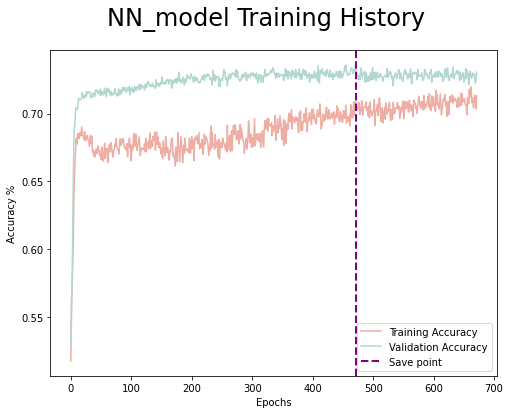

In [6]:
# plot train and val acc as a function of epochs
# your code here
def plot_history_acc(history):

    fig, ax = plt.subplots(1,1,figsize = (8,6))
    ax.plot(history.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
    ax.plot(history.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
    if len(history.history['val_accuracy']) < 1200:
        ax.axvline(len(history.history['val_accuracy'])-200, color='purple', linestyle='dashed', linewidth=2, label='Save point')

    ax.legend()
    ax.set_xlabel('Epochs');
    ax.set_ylabel('Accuracy %');
    fig.suptitle('NN_model Training History', fontsize = 24)
    
plot_history_acc(history)

In [7]:
# your code here

# evaluate the model accuracy with train set and test set 
train_accuracy = NN_model.evaluate(X_train,y_train)[1]
test_accuracy = NN_model.evaluate(X_test,y_test)[1]
print("NN_model_train_acc:", train_accuracy)
print("NN_model_test_acc:", test_accuracy)

63/63 [==============================] - 0s 710us/step - loss: 0.6461 - accuracy: 0.7270
NN_model_train_acc: 0.7528749704360962
NN_model_test_acc: 0.7269999980926514


<div class='exercise-r'>

**1.3**

</div>

In [8]:
# your code here

# 1.3.1
# generate logreg dataset
# Convert probabilities into labels
# X_train_logreg = X_train
y_train_hat = NN_model.predict(X_train)
y_train_logreg = np.round(y_train_hat).ravel()


# X_test_logreg = X_test
# y_test_hat = NN_model.predict(X_test)
# y_test_logreg = np.round(y_test_hat).ravel()

In [9]:
# 1.3.2
# Fit the logistic regression model
logreg = LogisticRegression(penalty='l2', max_iter=1000)
logreg.fit(X_train, y_train_logreg)

# Print the logreg test accuracy
y_test_logreg_hat = logreg.predict(X_test)
print("logreg_model_test_acc:", accuracy_score(y_test_logreg_hat, y_test))

logreg_model_test_acc: 0.7255


<function matplotlib.pyplot.show(close=None, block=None)>

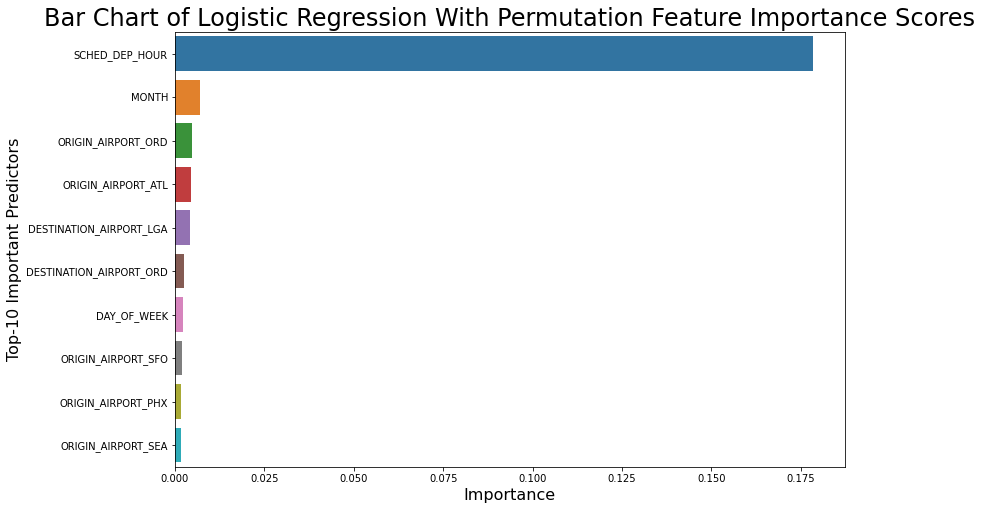

In [10]:
# 1.3.3
# compute the feature importances use permutation_importance
logreg_importance  = permutation_importance(logreg, X_test, y_test, n_jobs=-1)

# Generate and sort feature importances dataframe
feature_importance = pd.DataFrame()
feature_importance['features'] = X.columns
feature_importance['importance'] = logreg_importance.importances_mean
feature_importance=feature_importance.sort_values('importance',ascending=False)

# Plot the top-10 feature importances
plt.figure(figsize=[12,8])
ax2 = sns.barplot(x='importance',y='features',data=feature_importance[:10])
ax2.set_title('Bar Chart of Logistic Regression With Permutation Feature Importance Scores', fontsize = 24)
ax2.set_xlabel('Importance', fontsize = 16)
ax2.set_ylabel('Top-10 Important Predictors', fontsize = 16)
plt.show

<div class='exercise-r'>

**1.4**    

**1.4.1**

</div>

In [11]:
# your code here

# examining the response as a function of any of the predictors
def predictors_examining_14(examining_predictors, NN_model):
    '''
    input:
        examining_predictors: list of strings, the names of the predictors to examine
        NN_model: the trained model
    output:
        None(just print the plot)
    '''

    # set all predictors to their means of scaled values except the examining variables

    # get the original data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
    # get the column index of the examining variables
    examining_predictors_index = X_train.columns.get_indexer(examining_predictors)
    
    # scale the data and get the mean of the scaled data
    scaler_temp = StandardScaler()
    X_train_temp = scaler_temp.fit_transform(X_train)
    X_train_final = X_train_temp.copy()
    X_train_final[:]= X_train_temp.mean(axis=0)
    # keep the examing variables to their scaled values
    X_train_final[:,examining_predictors_index] = X_train_temp[:,examining_predictors_index]
    # predict the probability of delay with the new data
    y_train_hat = NN_model.predict(X_train_final)



    # plot the predicted probabilities of delay vs. examining predictors on the training set.
    # set the first axis
    fig, ax1 = plt.subplots(figsize=(14,7))
    ax1.set_title('Predicted Probability of Delay vs. '+' & '.join(examining_predictors), fontsize=24)
    ax1.set_xlabel('Predicted Probability of Delay', fontsize=16)
    ax1.set_ylabel('Original '+examining_predictors[0], color='b', fontsize=16)
    s1 = ax1.scatter(y_train_hat, X_train[examining_predictors[0]], c='b', marker='o', label=examining_predictors[0])
    ax1.tick_params(axis='y', labelcolor='b')

    # set the second axis(if have more than one examining variables)
    if len(examining_predictors) == 1:
        ax1.legend(loc=0, fontsize=12)
        plt.show()
    else:
        # Create a second Y-axis that shares the X-axis
        ax2 = ax1.twinx()
        ax2.set_ylabel('Original '+examining_predictors[1], color='r', fontsize=16)
        s2 = ax2.scatter(y_train_hat, X_train[examining_predictors[1]], c='r', marker='o', label=examining_predictors[1])
        ax2.tick_params(axis='y', labelcolor='r')

        # Add the legend to the plot
        sca = [s1,s2]
        labels = [lable.get_label() for lable in sca]
        plt.legend(sca, labels,loc = 2, fontsize=12)

        plt.show()

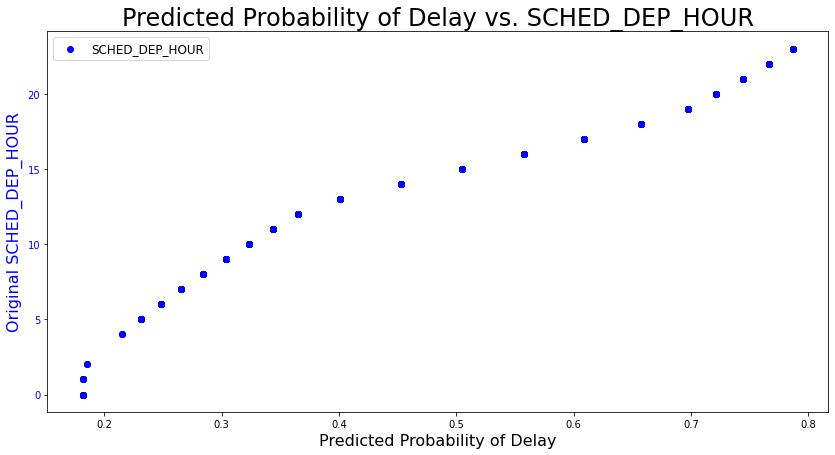

In [12]:
# except SCHED_DEP_HOUR
predictors_examining_14(['SCHED_DEP_HOUR'], NN_model)

**INTERPRETATION:**

*Your answer here*  
As the departure time increases from 0 to 24, the probability of delay increases. This may be due to the accumulation of delays, resulting in more delays for later flights. Also, the increasing trend in the probability of delay varies widely from time to time, and we believe this is related to how busy the airport is at the time.


<div class='exercise-r'>

**1.4.2**
</div>

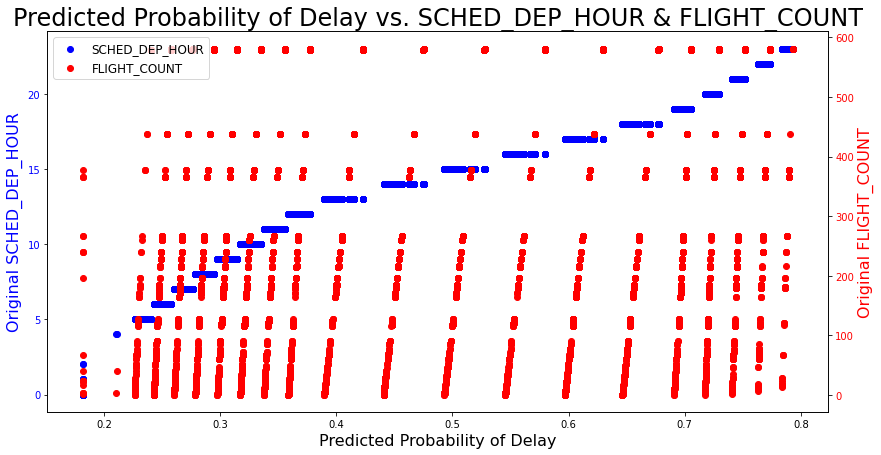

In [13]:
# your code here
predictors_examining_14(['SCHED_DEP_HOUR','FLIGHT_COUNT'], NN_model)

<div class='exercise-r'>

**1.4.3**
    
</div>

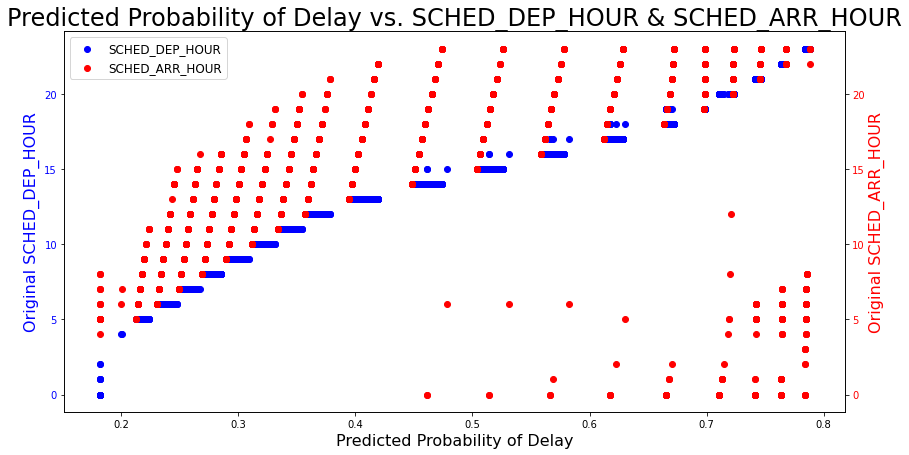

In [14]:
# your code here
predictors_examining_14(['SCHED_DEP_HOUR','SCHED_ARR_HOUR'], NN_model)

<div class='exercise-r'>

**1.4.4**
    
</div>

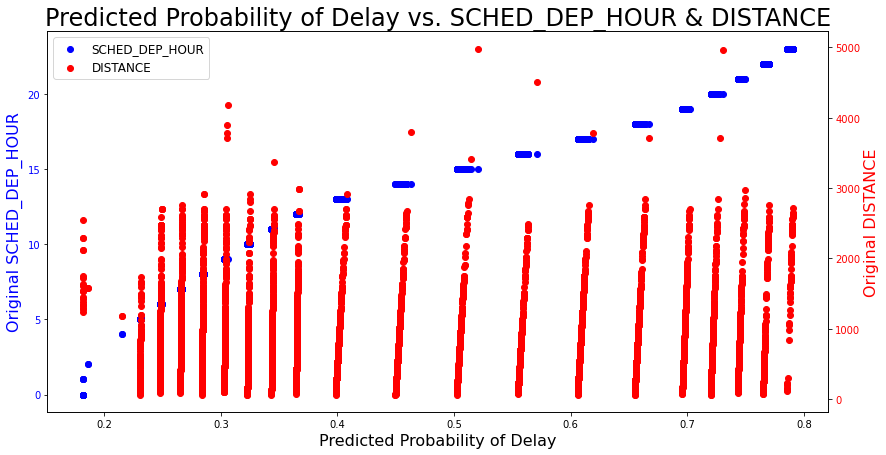

In [15]:
# your code here
predictors_examining_14(['SCHED_DEP_HOUR','DISTANCE'], NN_model)

<div class='exercise-r'>

**1.4.5**
    
</div>

**INTERPRETATION:**

*your answer here*  
The two variables in 1.4.2 to 1.4.4 jointly determine the probability of delay, and SCHED_DEP_HOUR has a greater effect on the probability than the other variable.  
In 1.4.2 the number of flights per day can be concentrated in the range of 0-300, and the probability of delay increases slightly with the number of flights. It can be inferred from this that a busy airport increases the probability of delay.  
In 1.4.3, the probability of delay increases slightly as the arrival time increases from 0 to 24, and it should be noted that the dot in the lower right corner is for the next day's arrival (the high probability of delay is mainly affected by the late departure time of the previous day).  
In 1.4.4, we can see that the flight distance is concentrated between 0 and 3000 miles, and the delay probability increases slightly as the flight distance increases.  
Comparing these three plots with 1.4.1, it is not difficult to find that SCHED_DEP_HOUR dominates the effect on the delay probability after adding three other variables respectively. This is consistent with the results of the importance score plot obtained in 1.3.3.


<div class='exercise-r'>

**1.5**

</div>

In [16]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [17]:
# build and compile the model
def buildModel(learning_rate = 0.0005):
  '''
  input:
    learning_rate: float, the learning rate of the model
  output:
    model: the model
  '''

  # build NN model

  # model parameters
  n_input = X_train.shape[1]
  n_hidden = 15
  n_output = 1
  # Max-norm 
  # Constrains the weights incident to each hidden unit to have a norm less than or equal to a desired value.
  maxnorm_constraint = tf.keras.constraints.MaxNorm(max_value=1, axis=0)

  # define the model
  model = tf.keras.models.Sequential(name='NN_model')
  model.add((tf.keras.layers.Dense(n_hidden, input_dim=n_input, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm_constraint, kernel_regularizer='l1_l2')))
  model.add((tf.keras.layers.Dense(n_hidden, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm_constraint, kernel_regularizer='l1_l2')))
  model.add((tf.keras.layers.Dense(n_output, activation = 'sigmoid')))

  # compile the model
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [18]:
%%time
# Bootstrap and train your networks and get predictions on fixed X test data
# your code here
bootstraps = 100
epochs = 400
batch_size = 256
learning_rate = 0.0005

boot_models = []
for i in range(bootstraps):

    # progress bar
    progressbar(i, bootstraps)

    # build, compile and train the model
    boot_X_train, boot_y_train = resample(X_train, y_train, replace=True, n_samples=int(X_train.shape[0]))
    boot_model = buildModel(learning_rate=learning_rate)

    boot_model.fit(boot_X_train, boot_y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # save model
    boot_models.append(boot_model)

 [==================================================] 100/100 Done...

Wall time: 25min 27s


In [19]:
# ramdomly select 8 test observations
boot_X_test, boot_y_test = resample(X_test, y_test, replace=0, n_samples=8)
boot_y_hat = np.zeros((bootstraps, boot_X_test.shape[0]))
for i in range(bootstraps):
    boot_y_hat[i] = boot_models[i].predict(boot_X_test).reshape(-1)
boot_y_hat = boot_y_hat.T

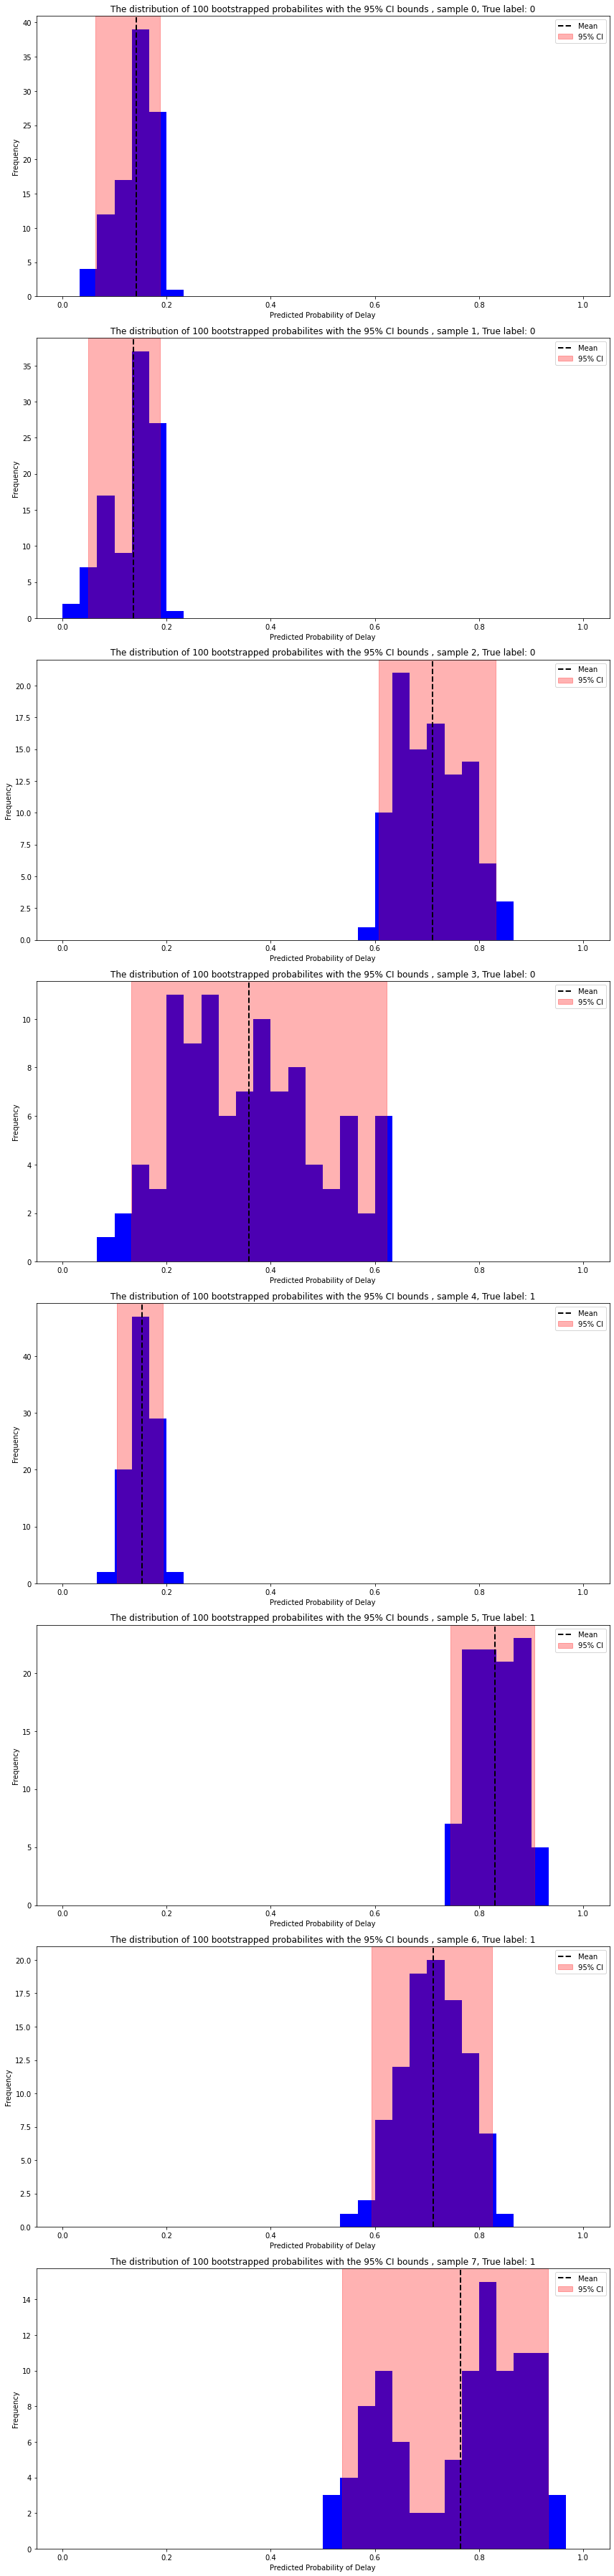

In [20]:
# generate your plot
# your code here

# plot the distribution of predicted probabilities with the 95% CI bounds clearly marked and reported in each subplot
fig, ax = plt.subplots(8, 1, figsize=(12, 50))
for i in range(8):
    ax[i].set_title(f'The distribution of {bootstraps} bootstrapped probabilites with the 95% CI bounds , sample {i}, True label: {boot_y_test.iloc[i]}')
    ax[i].hist(boot_y_hat[i], bins=30, range=(0, 1), color='blue')
    ax[i].axvline(boot_y_hat[i].mean(), color='k', linestyle='dashed', linewidth=2, label='Mean')
    ax[i].axvspan(np.percentile(boot_y_hat[i], 2.5), np.percentile(boot_y_hat[i], 97.5), color='red', alpha=0.3, label='95% CI')
    ax[i].set_xlabel('Predicted Probability of Delay')
    ax[i].set_ylabel('Frequency')
    ax[i].legend()
fig.tight_layout()
plt.show() 


**INTERPRETATION:**

*your answer here*  
Models trained using data from resample have predicted values within a range for a given observation. It means that ensemble, based on resampling, does not give a significant improvement in model performance, but only ensures that the model results are more stable (avoiding extreme values). The confidence of models is higher when the probabilities distribution is concentrated at 0 or 1. Based on these pictures, we speculate that the probabilities become normally distributed when the number of bootstrap is large enough.

<div class='exercise-r'>

**1.6**

</div>

In [21]:
# your code here

# predict all test data with the bootstrapped models
boot_y_hat_all = np.zeros((bootstraps, X_test.shape[0]))
for i in range(bootstraps):
    boot_y_hat_all[i] = boot_models[i].predict(X_test).reshape(-1)
boot_y_hat_all = boot_y_hat_all.T

# calculate posterior prediction ratio
boot_y_hat_label = np.round(boot_y_hat_all)
PPR = (boot_y_hat_label==0).mean(axis=1)

In [22]:
# # plot the distribution of posterior prediction ratios
# plt.hist(PPR, bins=30, range=(0, 1), color='blue')
# plt.axvline(PPR.mean(), color='k', linestyle='dashed', linewidth=2, label='Mean')
# plt.axvspan(np.percentile(PPR, 2.5), np.percentile(PPR, 97.5), color='red', alpha=0.3, label='95% CI')
# plt.xlabel('Posterior Prediction Ratio')
# plt.ylabel('Frequency')
# plt.legend()
# plt.show()

In [23]:
# create a abstain bagging model
def abstain_bagging_model(threshold=0.5):
    '''
    input:
        threshold: the maximun of the PPR
    output:
        The rest of the samples, accuracy and proportion of the samples that not abstained
    '''

    # delete the abstained samples
    indexes = np.where(PPR <= threshold)
    X, y = X_test[indexes], y_test.iloc[indexes]

    # calculate the proportion of the samples that not abstained
    proportion = X.shape[0]/X_test.shape[0]

    # calculate the accuracy
    acc = ((np.round(boot_y_hat_all[indexes]).sum(axis=1)>(len(boot_models)/2))==y_test.iloc[indexes]).mean()

    return X, y, acc, proportion

In [24]:
# print the accuracy of the bagging model
print(f'The accuracy of the bagging model is {abstain_bagging_model(threshold=1)[2]}')

The accuracy of the bagging model is 0.7215


In [25]:
# test accuracy and proportion of test observations not abstained for abstain bagging model
def  plot_acc_proportion_16(start, end, step):
    '''
    input:
        start: the start of the range
        end: the end of the range
        step: the step of the range
    output:
        plot the accuracy and proportion of the samples that not abstained
    '''

    # generate the data for the next part
    arr = np.arange(start, end, step)
    accs=[]
    pros=[]
    for i in arr:
        _, _, acc, proportion = abstain_bagging_model(threshold=i)
        accs.append(acc)
        pros.append(proportion)


    # plot accuracies and proportion of test observations not abstained for abstain bagging model
    
    # plot accuracies
    # set the first axis
    fig16, ax16 = plt.subplots(figsize=(14,7))
    ax16.set_title('PPR Threshold vs. Accuracy and Rest Propotion of Test Observation', fontsize=24)
    ax16.set_xlabel('Posterior Prediction Ratio Threshlod', fontsize=16)
    ax16.set_ylabel('Accuracy of abstain bagging model', color='b', fontsize=16)
    s1 = ax16.plot(arr, accs, c='b', label='Accuracy')
    ax16.tick_params(axis='y', labelcolor='b')
    ax16.legend(loc=0,)

    # plot the proportion of test observations not abstained
    # Create a second Y-axis that shares the X-axis
    ax2 = ax16.twinx()
    ax2.set_ylabel('Rest ratio of test observation', color='r', fontsize=16)
    s2 = ax2.plot(arr, pros, c='r', label='Rest Propotion')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc=0,)

    # fig16.tight_layout()
    plt.show()

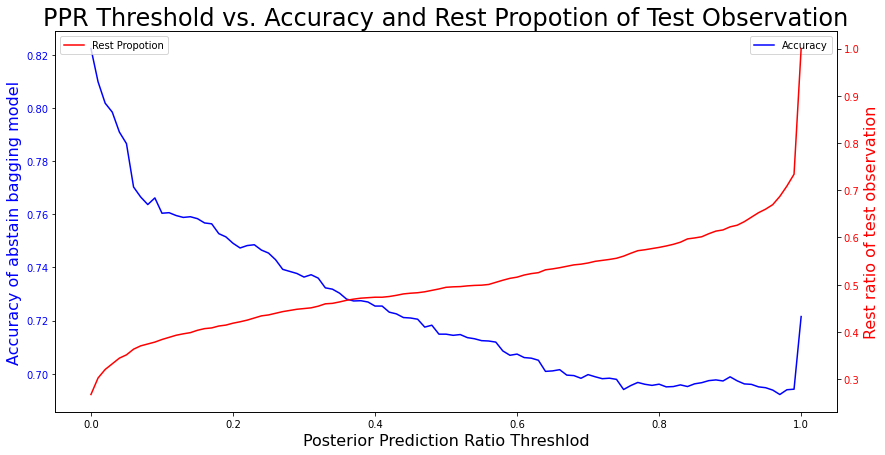

In [26]:
# test accuracy and proportion of test observations not abstained for abstain bagging model when the threshold is increased
plot_acc_proportion_16(0, 1.01, 0.01)

**INTERPRETATION:**

*your answer here*  
From the figure with PPR=1, we can see that the hard voting ensemble method with only resampling cannot make significant improvement in the model performance. However, we can improve the accuracy of the ensemble model by controlling the PPR threshold,so that the model only makes predictions for observations with confidence. As the threshold decreases, the abstain bagging model performs better, but the number of observations that can be predicted with confidence decreases. Meanwhile, according to the curve of the proportion of remaining observations, it can be judged that the distribution of PPR has a U-shape curve, which means that the model has a uniform opinion on most observations.


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">


<h1>PART 2 [50 pts]: Kannada MNIST</h1>
<br /><br />
[Return to contents](#contents)
<br /><br />

<a id="part2intro"></a>
<h2> Problem Statement </h2>
<br /><br />
[Return to contents](#contents)
<br /><br />

ANNs can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns do not generalize to new data.
<br /><br />
There are several methods used to improve ANN generalization. 
<br /><br />
One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.
<br /><br />
However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization".
<br /><br />
In this problem, you are asked to regularize a network of a given architecture.

<a id="part2about"></a>
<br /><br />
<h3> The Kannada MNIST Dataset </h3>
<br /><br />
[Return to contents](#contents)
<br /><br />

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)

<br /><br />
For this problem, we will be working with a modified version of [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf) , which is a large database of handwritten digits in the indigenous language *Kannada*.
<br /><br />
This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. 
<br /><br />
For this homework, we will simplify the problem by only use the digits labeled `0` and `1` owing to the similarity of the two symbols, and we want to use a total of 1200 samples for training (this includes the data you will use for validation).
<br /><br />
To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.
<br /><br />
<a id="part2data"></a>

<h4> Downloading the Data Files </h4>
<br />
[Return to contents](#contents)
<br />
Please download all files from resources on Ed.
<br /><br />
Here's a brief description of the available files:
<br /><br />
- `kmnist_train.csv` is our training dataset and the last column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image.
<br /><br />
Class 0 means a sample is the handwritten digit `0` and class 1 means a sample is the handwritten digit `1` in the Kannada language.  
<br />
- `kmnist_test.csv` has a structure similar to `kmnist_train.csv` but you will use this only for testing.
    
</div>    

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

<h2>PART2 Questions</h2>
<br /><br />
[Return to contents](#contents)

<br /><br />
**2.1 [5 points]** **Get the data:**

- Download data from Ed resources.
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1.
<br /><br />
    
**2.2 [15 points]** **Overfit an ANN:** 

Build a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: no more than 2,000
- Batch size: 128
- Validation size: 0.3

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 

<a id="part2_3"></a>
<br /><br />

**2.3 [30 points]** **Regularize overfit network:**

Create an ANN that doesn't overfit and report your accuracy on the test set.
<br /><br />
**DON'TS**

**Don't change the architecture**. In other words, keep the number of layers, number of nodes, activation function,  loss function and output unit the same. **No CNNs/RNNs/enhancements.**

<br />
    
**NOTE**: We strongly discourage you to use a different training set than the one provided to you but data augmentation is allowed. 

<br /><br />
    
**DOS**

You can change the number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize (e.g., dropout, L2 norm, etc.). You can also do data augmentation. 
<br /><br />

- **2.3.1** Display your model summary and your training and validation accuracy and loss.

<br />
    
- **2.3.2** Print the difference between the training and validation accuracies and the difference between the training and validation losses for the final trained epoch used by your model.

<br />
    
- **2.3.3** Plot the training accuracy and validation accuracy as a function of epochs.
<br />

- **2.3.4** Once your model is trained, evaluate your model on the test dataset and provide the test accuracy.


<br /><br />

</div>

<a id="part2solutions"></a>

## PART 2 Solutions

[Return to contents](#contents)


<div class='exercise-r'>

**2.1** 
    
</div>

In [27]:
# your code here 

# !!!!unzip the datasets, put the data into the "data" folder!!!!
# load data from the "data" folder
train2 = pd.read_csv('data/kmnist_train.csv')
test2 = pd.read_csv('data/kmnist_test.csv')

# split data into train and test
X2_train, y2_train = train2.iloc[:, :-1], train2.iloc[:, -1]
X2_test, y2_test = test2.iloc[:, :-1], test2.iloc[:, -1]

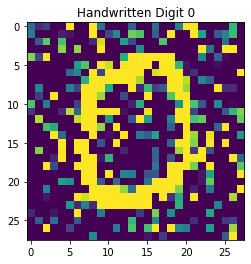

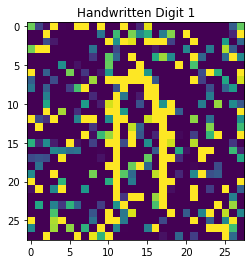

In [28]:
# handwritten digit 0
plt.imshow(X2_train[y2_train==0].iloc[0].values.reshape(28,28))
plt.title("Handwritten Digit 0")
plt.show()

# handwritten digit 1
plt.imshow(X2_train[y2_train==1].iloc[0].values.reshape(28,28))
plt.title("Handwritten Digit 1")
plt.show()

<div class='exercise-r'>

**2.2**
    
</div>

In [29]:
# your code here

# build the model 
model_overfit = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X2_train.shape[1],)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model_overfit.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
history_overfit = model_overfit.fit(X2_train, y2_train, epochs=1000, batch_size=128, validation_split=0.3, verbose=0)

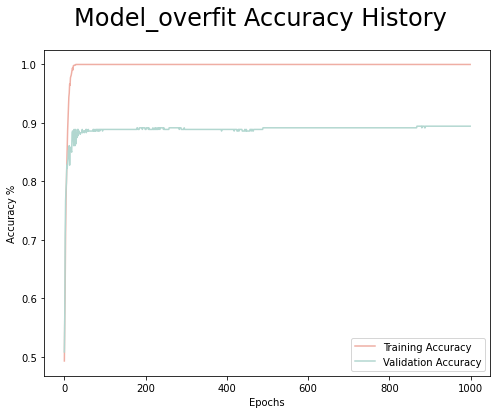

In [30]:
# plot the trainning accuracy and validation accuracy
def plot_history_acc_overfit(history):

    fig, ax = plt.subplots(1,1,figsize = (8,6))
    ax.plot(history.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
    ax.plot(history.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
    ax.legend()
    
    ax.set_xlabel('Epochs');
    ax.set_ylabel('Accuracy %');
    fig.suptitle('Model_overfit Accuracy History', fontsize = 24)
    
plot_history_acc_overfit(history_overfit)

**INTERPRETATION:**

*your answer here*  
When the accuracy of the training data is high and the accuracy of the test data is low, the model is over-fitted. From the figure, we can see that the accuracy of the training set has reached an impressive 100%, but the accuracy of the validation set is very different and stops growing after 300 epochs.


<div class='exercise-r'>

**2.3** 
    
</div>

**Reference Material**  
[Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)  
[Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)  
[Experiments with AMSGrad](https://fdlm.github.io/post/amsgrad/)  
  
We use:   
- L1_L2 regularization  
- Dropout + Max-nrom  
- Adam with AMSGrad  
- Early Stopping  
- Kaiming initialization(he_normal)

  
Tried, but improvement is not obvious:  
- BN layers  
- RMSprop, SGD  
- Augmentation(Useful, but slow when training(not tried with asynchronous), deprecated.)


In [31]:
# # Reshape the train and test data
# X2_train = X2_train.values.reshape((X2_train.shape[0], 28, 28, 1))
# X2_test = X2_test.values.reshape((X2_test.shape[0], 28, 28, 1))

# # Convert from int to float
# X2_train = X2_train.astype('float32')
# X2_test = X2_test.astype('float32')

In [32]:
# # set the parameters for augmentation
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15,
#                                                           rescale=1./255,
#                                                           # width_shift_range=5,
#                                                           # height_shift_range=5,
#                                                         #   shear_range=0.1,
#                                                           # zoom_range=0.15,
#                                                           # horizontal_flip=True,
#                                                           validation_split=0.3
#                                                           )

# # Fit the generator on the train data using the train data 
# # and 'training' subset
# train_generator = datagen.flow(X2_train, y2_train, batch_size=256, subset='training')

# # Fit the generator on the train data using the train data and 
# # 'validation' subset
# validation_generator = datagen.flow(X2_train, y2_train, batch_size=256, subset='validation')

In [33]:
# # Max-norm 
# # Constrains the weights incident to each hidden unit to have a norm less than or equal to a desired value.
# maxnorm_constraint = tf.keras.constraints.MaxNorm(max_value=1, axis=0)

# # build the model
# model_good = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=[28,28,1]),
#     tf.keras.layers.Flatten(input_shape=[28,28]),
#     tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm_constraint,kernel_regularizer='l1_l2'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm_constraint,kernel_regularizer='l1_l2'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm_constraint,kernel_regularizer='l1_l2'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# # compile the model
# # opt = tf.keras.optimizers.SGD(learning_rate=0.001)
# opt = tf.keras.optimizers.Adam(learning_rate=0.0005, amsgrad=True)
# model_good.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# # fit the model
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1000, restore_best_weights=True)
# history_good = model_good.fit(train_generator, epochs=1500, batch_size=256, validation_data=validation_generator, callbacks=[early_stop])

# model_good.evaluate(X2_test, y2_test)

In [34]:
# Max-norm 
# Constrains the weights incident to each hidden unit to have a norm less than or equal to a desired value.
maxnorm_constraint = tf.keras.constraints.MaxNorm(max_value=1, axis=0)

# build the model
model_good = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X2_train.shape[1],)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm_constraint,kernel_regularizer='l1_l2'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm_constraint,kernel_regularizer='l1_l2'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', kernel_constraint=maxnorm_constraint,kernel_regularizer='l1_l2'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
# opt = tf.keras.optimizers.SGD(learning_rate=0.001)
opt = tf.keras.optimizers.Adam(learning_rate=0.0005, amsgrad=True)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model_good.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# fit the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1000, restore_best_weights=True)
history_good = model_good.fit(X2_train, y2_train, epochs=2000, batch_size=256, validation_split=0.3, callbacks=[early_stop], verbose=0)

<div class='exercise-r'>

**2.3.1**
    
</div>

In [35]:
# your code here

# model summary
model_good.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_307 (Dense)           (None, 100)               78500     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_308 (Dense)           (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_309 (Dense)           (None, 100)               10100     
                                                                 
 dense_310 (Dense)           (None, 1)                 101       
                                                                 
Total params: 98,801
Trainable params: 98,801
Non-trai

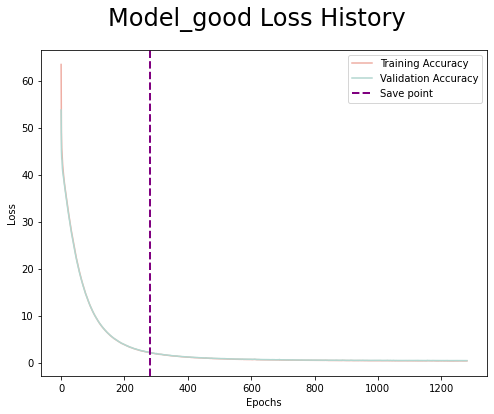

In [36]:
# train and validation loss
def plot_history_loss_good(history):

    fig, ax = plt.subplots(1,1,figsize = (8,6))
    ax.plot(history.history['loss'],color='#EFAEA4',label = 'Training Accuracy')
    ax.plot(history.history['val_loss'],color='#B2D7D0',label = 'Validation Accuracy')
    if len(history.history['val_loss']) < 2000:
        ax.axvline(len(history.history['val_loss'])-1000, color='purple', linestyle='dashed', linewidth=2, label='Save point')
    ax.legend()
    ax.set_xlabel('Epochs');
    ax.set_ylabel('Loss');

    fig.suptitle('Model_good Loss History', fontsize = 24)
    
plot_history_loss_good(history_good)

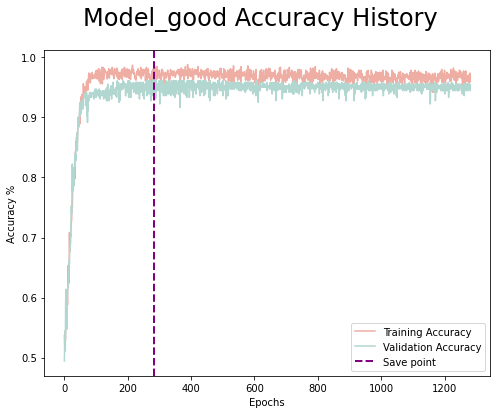

In [37]:
# train and validation accuracy
def plot_history_acc_good(history):

    fig, ax = plt.subplots(1,1,figsize = (8,6))
    ax.plot(history.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
    ax.plot(history.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
    if len(history.history['val_accuracy']) < 2000:
        ax.axvline(len(history.history['val_accuracy'])-1000, color='purple', linestyle='dashed', linewidth=2, label='Save point')
    ax.legend()
    ax.set_xlabel('Epochs');
    ax.set_ylabel('Accuracy %');

    fig.suptitle('Model_good Accuracy History', fontsize = 24)
    
plot_history_acc_good(history_good)

<div class='exercise-r'>

**2.3.2**
    
</div>

In [38]:
# your code here

# Print the difference between the training and validation accuracies and the difference between the training and validation losses for the final trained epoch used by your model.
# -1000 is for early stopping patience=1000
train_accuracy2 = history_good.history['accuracy'][-1000]
val_accuracy2 = history_good.history['val_accuracy'][-1000]
train_loss2 = history_good.history['loss'][-1000]
val_loss2 = history_good.history['val_loss'][-1000]

acc_diff = train_accuracy2 - val_accuracy2
loss_diff = train_loss2 - val_loss2

print(f'The training set accuracy for the regularized model is {train_accuracy2:.4f}\
    \nThe validation set accuracy for the regularized model is {val_accuracy2:.4f}\
    \nThe training set loss for the regularized model is {train_loss2:.4f}\
    \nThe validation set loss for the regularized model is {val_loss2:.4f}')
print()
print(f'The difference between the training and validation accuracies for the final trained epoch of regularized model is: {train_accuracy2:.4f} - {val_accuracy2:.4f} = {acc_diff:.4f}')
print(f'The difference between the training and validation losses for the final trained epoch of regularized model is: {train_loss2:.4f} - {val_loss2:.4f} = {loss_diff:.4f}')

The training set accuracy for the regularized model is 0.9786    
The validation set accuracy for the regularized model is 0.9556    
The training set loss for the regularized model is 2.0863    
The validation set loss for the regularized model is 2.1159

The difference between the training and validation accuracies for the final trained epoch of regularized model is: 0.9786 - 0.9556 = 0.0230
The difference between the training and validation losses for the final trained epoch of regularized model is: 2.0863 - 2.1159 = -0.0296


<div class='exercise-r'>

**2.3.3**
    
</div>

It should be noted that we used a **large patience (patience=1000)** for early stopping to prevent unstable results. Although the image show overfitting in the late training period, thanks to the early stop, we saved the model with the best performance on the validation set.

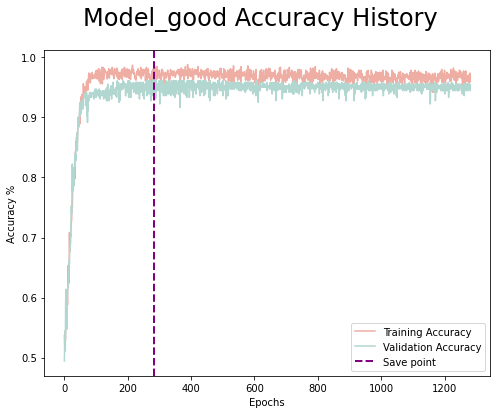

In [39]:
# your code here

# plot the trainning accuracy and validation accuracy
def plot_history_acc_good(history):

    fig, ax = plt.subplots(1,1,figsize = (8,6))
    ax.plot(history.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
    ax.plot(history.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
    if len(history.history['val_accuracy']) < 2000:
        ax.axvline(len(history.history['val_accuracy'])-1000, color='purple', linestyle='dashed', linewidth=2, label='Save point')
    ax.legend()
    
    ax.set_xlabel('Epochs');
    ax.set_ylabel('Accuracy %');
    fig.suptitle('Model_good Accuracy History', fontsize = 24)
    
plot_history_acc_good(history_good)

<div class='exercise-r'>

**2.3.4**
    
</div>

In [40]:
# your code here

# evaluate the model on the test data
good_test_acc = model_good.evaluate(X2_test, y2_test)[1]
print(f'The accuracy of our regularized model on test dataset is {good_test_acc:.4f}')

63/63 [==============================] - 0s 920us/step - loss: 2.1612 - accuracy: 0.9375
The accuracy of our regularized model on test dataset is 0.9375


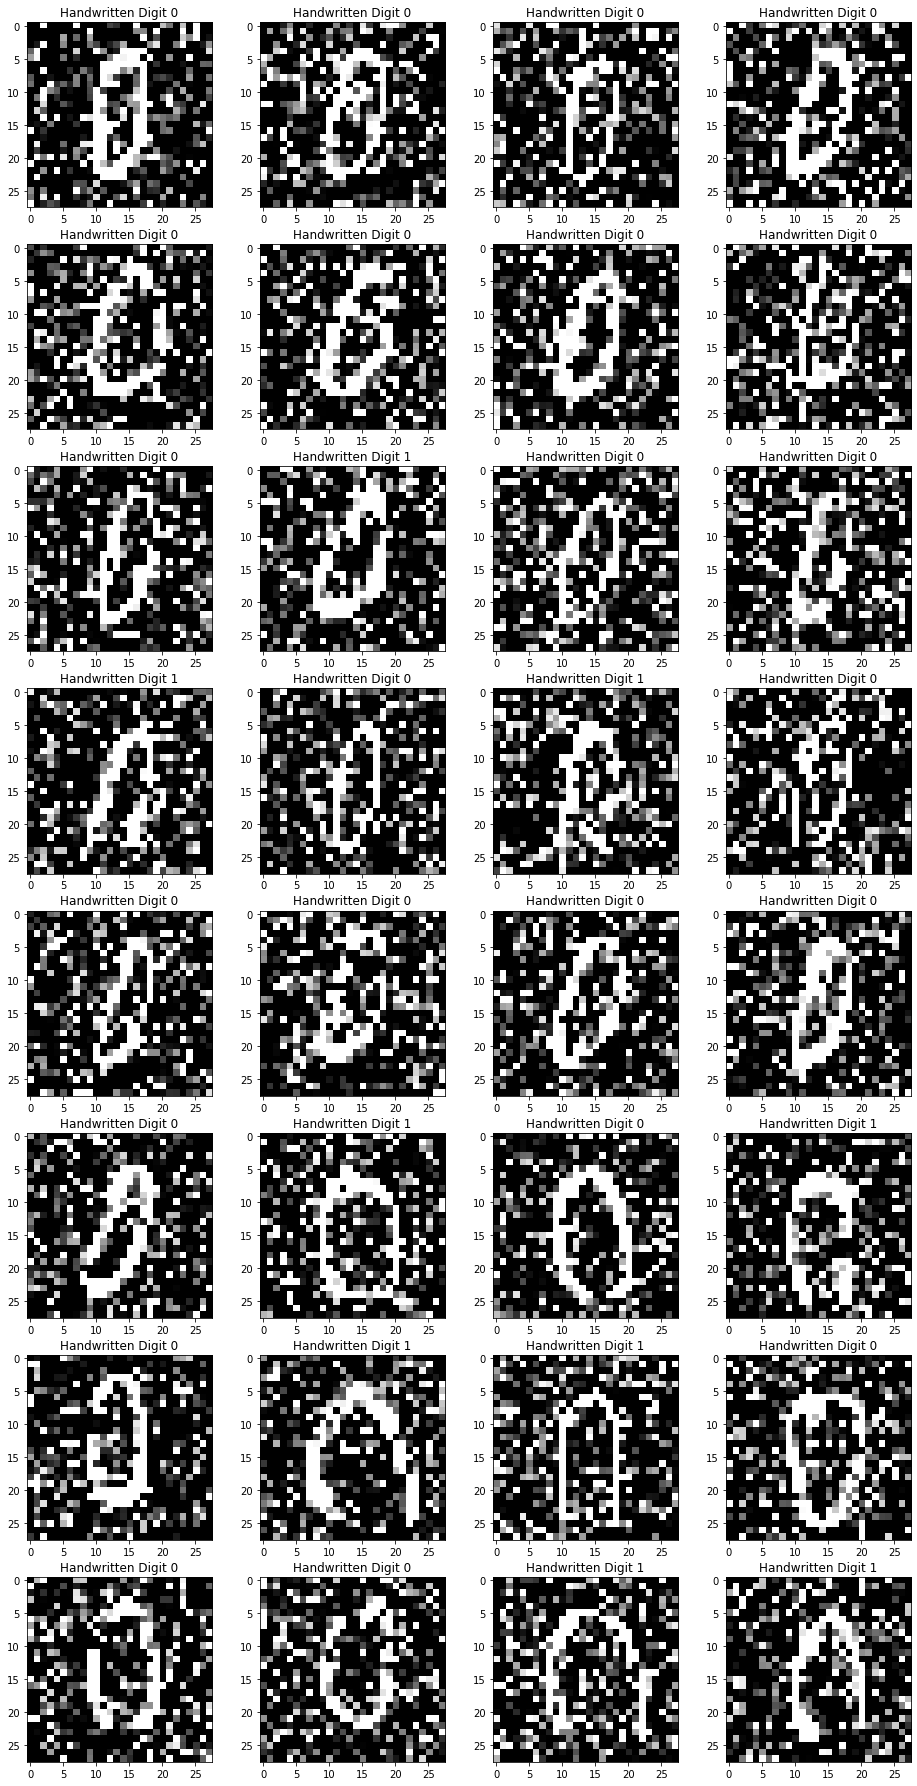

In [41]:
# check the bad(wrong) cases
a1 = model_good.predict(X2_test)
m1 = (np.round(a1).reshape(-1)==y2_test)==False
fig = plt.figure(figsize=(16,32))
ax = []
for i in range(32):
    ax.append(fig.add_subplot(8,4,i+1))
    ax[i].imshow(X2_test[m1].iloc[i].values.reshape(28,28), cmap='gray')
    ax[i].set_title(f'Handwritten Digit {y2_test[m1].iloc[i]}')
plt.show()